# トレンド分析 - Trend Analysis

このノートブックでは、LME銅先物データを使用してトレンド分析を実施し、価格の方向性とモメンタムを詳細に分析します。

## 分析の概要
1. **移動平均トレンド分析** - 短期・中期・長期トレンドの把握
2. **モメンタム分析** - 価格変動の勢いと持続性の評価
3. **テクニカル指標分析** - RSI、MACD、ボリンジャーバンド等
4. **トレンド強度分析** - ADX、方向性指数による定量評価
5. **サポート・レジスタンス分析** - 重要な価格水準の特定
6. **ブレイクアウト分析** - トレンド転換点の検出

In [ ]:
from config.database_config import get_connection_string
import sys
import os
import pandas as pd
import numpy as np
import pyodbc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks, find_peaks_cwt
import warnings

# プロジェクトルートをPythonパスに追加
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, project_root)


warnings.filterwarnings('ignore')

# 英語フォント設定（文字化け回避）
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 120

# カラーパレット
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#2ca02c',
    'quaternary': '#d62728',
    'quinary': '#9467bd',
    'uptrend': '#2ca02c',
    'downtrend': '#d62728',
    'sideways': '#ffa500'
}

print("ライブラリの読み込み完了")

ライブラリの読み込み完了


## データ読み込みと前処理

In [ ]:
def load_price_data(conn, days=365):
    """銅先物の詳細価格データの読み込み"""
    query = f"""
    SELECT 
        p.TradeDate,
        t.TenorTypeName,
        p.SettlementPrice as ClosePrice,
        p.OpenPrice,
        p.HighPrice,
        p.LowPrice,
        p.Volume,
        p.OpenInterest,
        CASE 
            WHEN t.TenorTypeName LIKE 'Generic 1st%' THEN 1
            WHEN t.TenorTypeName LIKE 'Generic 2nd%' THEN 2
            WHEN t.TenorTypeName LIKE 'Generic 3rd%' THEN 3
            WHEN t.TenorTypeName LIKE 'Generic 4th%' THEN 4
            WHEN t.TenorTypeName LIKE 'Generic 5th%' THEN 5
            WHEN t.TenorTypeName LIKE 'Generic 6th%' THEN 6
            ELSE NULL
        END as TenorNumber
    FROM T_CommodityPrice p
    INNER JOIN M_Metal m ON p.MetalID = m.MetalID
    INNER JOIN M_TenorType t ON p.TenorTypeID = t.TenorTypeID
    WHERE 
        m.MetalCode = 'COPPER'
        AND p.TradeDate >= DATEADD(day, -{days}, GETDATE())
        AND p.SettlementPrice IS NOT NULL
        AND p.OpenPrice IS NOT NULL
        AND p.HighPrice IS NOT NULL
        AND p.LowPrice IS NOT NULL
    ORDER BY p.TradeDate ASC, t.TenorTypeName
    """

    df = pd.read_sql(query, conn)
    df['TradeDate'] = pd.to_datetime(df['TradeDate'])
    df = df.dropna(subset=['TenorNumber'])
    return df


# データベース接続とデータ読み込み
conn = pyodbc.connect(get_connection_string())
df = load_price_data(conn, days=365)

# フロント月（第1限月）のデータを抽出
front_month_data = df[df['TenorNumber'] == 1].copy()
front_month_data = front_month_data.sort_values(
    'TradeDate').reset_index(drop=True)

print(
    f"データ期間: {df['TradeDate'].min().date()} - {df['TradeDate'].max().date()}")
print(f"総データ件数: {len(df):,}件")
print(f"フロント月データ件数: {len(front_month_data)}件")
print(f"利用可能限月: {sorted(df['TenorNumber'].unique())}")

# データの基本統計
if len(front_month_data) > 0:
    print(f"\nフロント月基本統計:")
    print(
        f"価格レンジ: ${front_month_data['ClosePrice'].min():.2f} - ${front_month_data['ClosePrice'].max():.2f}")
    print(f"平均価格: ${front_month_data['ClosePrice'].mean():.2f}")
    print(f"平均出来高: {front_month_data['Volume'].mean():,.0f}")

データ期間: 2024-07-05 - 2025-07-04
総データ件数: 1,509件
フロント月データ件数: 253件
利用可能限月: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

フロント月基本統計:
価格レンジ: $8577.37 - $10118.42
平均価格: $9335.42
平均出来高: 15,503


## テクニカル指標の計算関数

In [ ]:
def calculate_technical_indicators(data):
    """
    各種テクニカル指標を計算する関数
    """
    df = data.copy()

    # 移動平均線
    df['SMA_5'] = df['ClosePrice'].rolling(window=5).mean()
    df['SMA_10'] = df['ClosePrice'].rolling(window=10).mean()
    df['SMA_20'] = df['ClosePrice'].rolling(window=20).mean()
    df['SMA_50'] = df['ClosePrice'].rolling(window=50).mean()

    # 指数移動平均
    df['EMA_12'] = df['ClosePrice'].ewm(span=12).mean()
    df['EMA_26'] = df['ClosePrice'].ewm(span=26).mean()

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # RSI
    delta = df['ClosePrice'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # ボリンジャーバンド
    df['BB_Middle'] = df['ClosePrice'].rolling(window=20).mean()
    bb_std = df['ClosePrice'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
    df['BB_Position'] = (df['ClosePrice'] - df['BB_Lower']
                         ) / (df['BB_Upper'] - df['BB_Lower'])

    # ATR (Average True Range)
    df['TR1'] = df['HighPrice'] - df['LowPrice']
    df['TR2'] = abs(df['HighPrice'] - df['ClosePrice'].shift(1))
    df['TR3'] = abs(df['LowPrice'] - df['ClosePrice'].shift(1))
    df['TR'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14).mean()

    # ADX (Average Directional Index)
    df['DM_Plus'] = np.where((df['HighPrice'] - df['HighPrice'].shift(1)) > (df['LowPrice'].shift(1) - df['LowPrice']),
                             np.maximum(df['HighPrice'] - df['HighPrice'].shift(1), 0), 0)
    df['DM_Minus'] = np.where((df['LowPrice'].shift(1) - df['LowPrice']) > (df['HighPrice'] - df['HighPrice'].shift(1)),
                              np.maximum(df['LowPrice'].shift(1) - df['LowPrice'], 0), 0)

    df['DI_Plus'] = 100 * (df['DM_Plus'].rolling(window=14).mean() / df['ATR'])
    df['DI_Minus'] = 100 * \
        (df['DM_Minus'].rolling(window=14).mean() / df['ATR'])
    df['DX'] = 100 * abs(df['DI_Plus'] - df['DI_Minus']) / \
        (df['DI_Plus'] + df['DI_Minus'])
    df['ADX'] = df['DX'].rolling(window=14).mean()

    # ストキャスティクス
    low_14 = df['LowPrice'].rolling(window=14).min()
    high_14 = df['HighPrice'].rolling(window=14).max()
    df['Stoch_K'] = 100 * (df['ClosePrice'] - low_14) / (high_14 - low_14)
    df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()

    # 出来高関連指標
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

    # トレンド判定
    df['Trend_Short'] = np.where(df['ClosePrice'] > df['SMA_10'], 1,
                                 np.where(df['ClosePrice'] < df['SMA_10'], -1, 0))
    df['Trend_Medium'] = np.where(df['ClosePrice'] > df['SMA_20'], 1,
                                  np.where(df['ClosePrice'] < df['SMA_20'], -1, 0))
    df['Trend_Long'] = np.where(df['ClosePrice'] > df['SMA_50'], 1,
                                np.where(df['ClosePrice'] < df['SMA_50'], -1, 0))

    return df


# テクニカル指標の計算
if len(front_month_data) > 60:  # 十分なデータがある場合のみ
    tech_data = calculate_technical_indicators(front_month_data)
    print("\nテクニカル指標の計算完了")
    print(
        f"計算済み指標数: {len([col for col in tech_data.columns if col not in front_month_data.columns])}個")
else:
    print("テクニカル指標計算に十分なデータがありません")
    tech_data = front_month_data.copy()


テクニカル指標の計算完了
計算済み指標数: 33個


## 1. 移動平均トレンド分析

### 分析目的
短期・中期・長期の移動平均線を用いてトレンドの方向性と強度を把握し、トレンドフォロー戦略の基礎情報を提供します。

### 分析手法
- **短期移動平均（5日・10日）**: デイトレード・スイングトレード向けの短期トレンド
- **中期移動平均（20日）**: ポジショントレード向けの中期トレンド
- **長期移動平均（50日）**: 投資判断向けの長期トレンド
- **移動平均の傾き**: トレンドの勢いを定量化

### グラフの見方・解釈
- **ゴールデンクロス**: 短期移動平均が長期移動平均を上抜け → 買いシグナル
- **デッドクロス**: 短期移動平均が長期移動平均を下抜け → 売りシグナル
- **移動平均の並び**: 上昇トレンド時は短期＞中期＞長期の順に配列
- **価格と移動平均の乖離**: 大きな乖離は調整の可能性を示唆

移動平均トレンド分析対象期間: 2024-09-13 - 2025-07-04


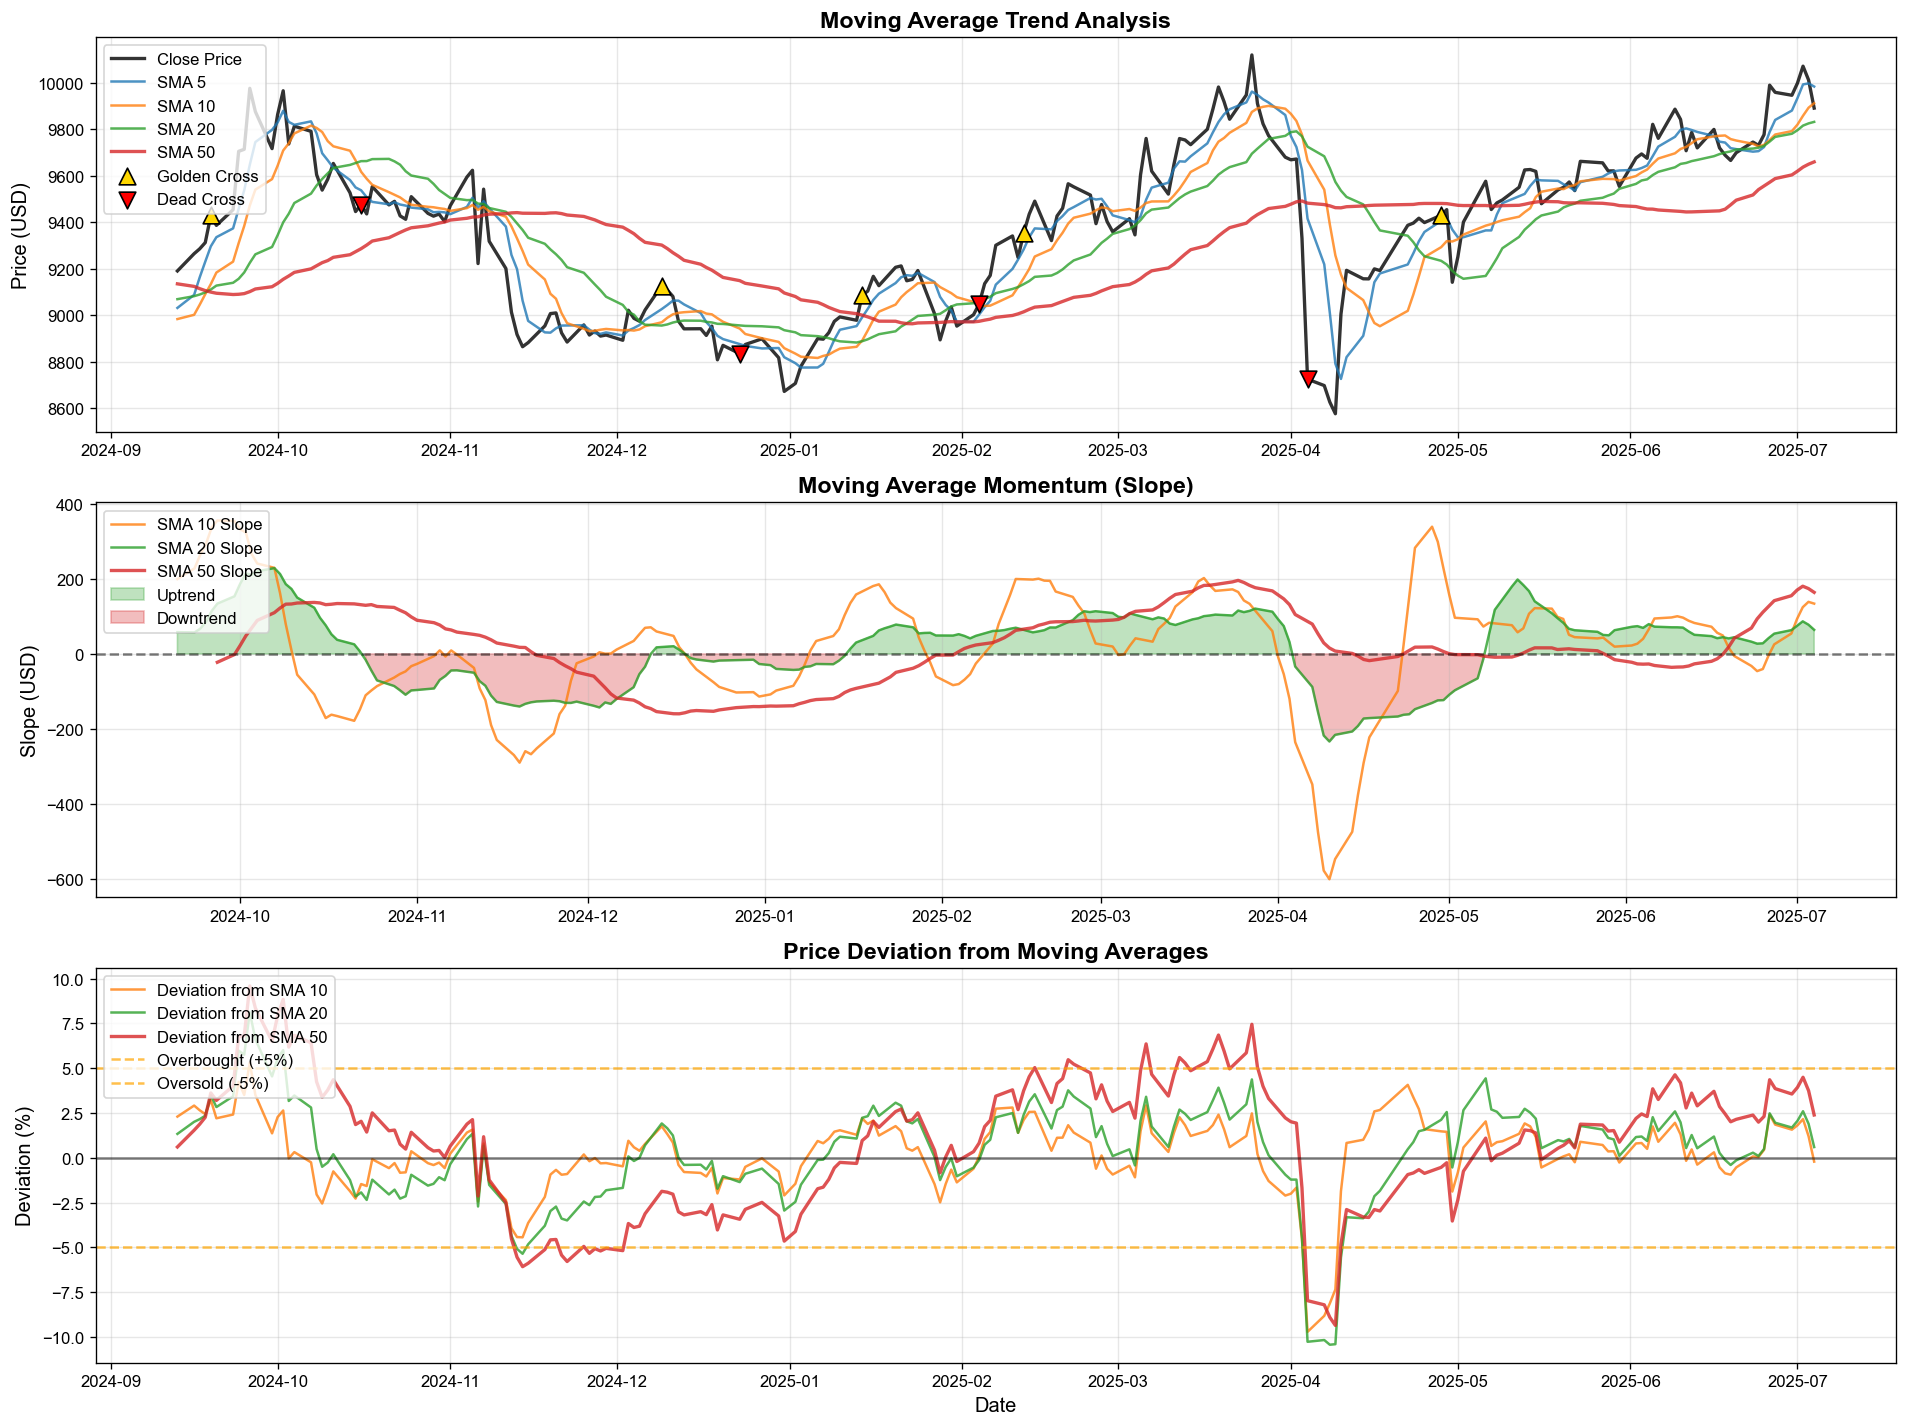


📈 移動平均トレンド分析結果:
現在価格: $9890.00
SMA 10: $9910.99 (乖離: -0.21%)
SMA 20: $9830.92 (乖離: 0.60%)
SMA 50: $9659.04 (乖離: 2.39%)

現在のトレンド状況: 強い上昇トレンド

直近のシグナル:
  2025-02-12: ゴールデンクロス (価格: $9352.52)
  2025-04-04: デッドクロス (価格: $8725.91)
  2025-04-28: ゴールデンクロス (価格: $9430.10)


In [ ]:
# 移動平均トレンド分析
if 'SMA_50' in tech_data.columns and len(tech_data.dropna(subset=['SMA_50'])) > 20:

    # データのクリーニング
    plot_data = tech_data.dropna(
        subset=['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50']).copy()

    if len(plot_data) > 0:
        print(
            f"移動平均トレンド分析対象期間: {plot_data['TradeDate'].min().date()} - {plot_data['TradeDate'].max().date()}")

        # トレンド転換点の検出
        plot_data['MA_Cross_Signal'] = 0

        # ゴールデンクロス・デッドクロスの検出（10日線と20日線）
        for i in range(1, len(plot_data)):
            if (plot_data.iloc[i]['SMA_10'] > plot_data.iloc[i]['SMA_20'] and
                    plot_data.iloc[i-1]['SMA_10'] <= plot_data.iloc[i-1]['SMA_20']):
                plot_data.iloc[i, plot_data.columns.get_loc(
                    'MA_Cross_Signal')] = 1  # ゴールデンクロス
            elif (plot_data.iloc[i]['SMA_10'] < plot_data.iloc[i]['SMA_20'] and
                  plot_data.iloc[i-1]['SMA_10'] >= plot_data.iloc[i-1]['SMA_20']):
                plot_data.iloc[i, plot_data.columns.get_loc(
                    'MA_Cross_Signal')] = -1  # デッドクロス

        # 可視化
        fig, axes = plt.subplots(3, 1, figsize=(16, 12))

        # 1. 価格と移動平均線
        axes[0].plot(plot_data['TradeDate'], plot_data['ClosePrice'],
                     linewidth=2, color='black', label='Close Price', alpha=0.8)
        axes[0].plot(plot_data['TradeDate'], plot_data['SMA_5'],
                     linewidth=1.5, color=COLORS['primary'], label='SMA 5', alpha=0.8)
        axes[0].plot(plot_data['TradeDate'], plot_data['SMA_10'],
                     linewidth=1.5, color=COLORS['secondary'], label='SMA 10', alpha=0.8)
        axes[0].plot(plot_data['TradeDate'], plot_data['SMA_20'],
                     linewidth=1.5, color=COLORS['tertiary'], label='SMA 20', alpha=0.8)
        axes[0].plot(plot_data['TradeDate'], plot_data['SMA_50'],
                     linewidth=2, color=COLORS['quaternary'], label='SMA 50', alpha=0.8)

        # ゴールデンクロス・デッドクロスのマーク
        golden_cross = plot_data[plot_data['MA_Cross_Signal'] == 1]
        dead_cross = plot_data[plot_data['MA_Cross_Signal'] == -1]

        if len(golden_cross) > 0:
            axes[0].scatter(golden_cross['TradeDate'], golden_cross['ClosePrice'],
                            color='gold', s=100, marker='^', label='Golden Cross',
                            edgecolors='black', linewidth=1, zorder=5)

        if len(dead_cross) > 0:
            axes[0].scatter(dead_cross['TradeDate'], dead_cross['ClosePrice'],
                            color='red', s=100, marker='v', label='Dead Cross',
                            edgecolors='black', linewidth=1, zorder=5)

        axes[0].set_title('Moving Average Trend Analysis',
                          fontsize=14, weight='bold')
        axes[0].set_ylabel('Price (USD)', fontsize=12)
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        # 2. 移動平均の傾き（トレンドの勢い）
        plot_data['SMA_10_Slope'] = plot_data['SMA_10'].diff(5)  # 5日間の変化
        plot_data['SMA_20_Slope'] = plot_data['SMA_20'].diff(5)
        plot_data['SMA_50_Slope'] = plot_data['SMA_50'].diff(10)  # 10日間の変化

        axes[1].plot(plot_data['TradeDate'], plot_data['SMA_10_Slope'],
                     linewidth=1.5, color=COLORS['secondary'], label='SMA 10 Slope', alpha=0.8)
        axes[1].plot(plot_data['TradeDate'], plot_data['SMA_20_Slope'],
                     linewidth=1.5, color=COLORS['tertiary'], label='SMA 20 Slope', alpha=0.8)
        axes[1].plot(plot_data['TradeDate'], plot_data['SMA_50_Slope'],
                     linewidth=2, color=COLORS['quaternary'], label='SMA 50 Slope', alpha=0.8)

        axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1].fill_between(plot_data['TradeDate'], 0, plot_data['SMA_20_Slope'],
                             where=(plot_data['SMA_20_Slope'] > 0),
                             color=COLORS['uptrend'], alpha=0.3, label='Uptrend')
        axes[1].fill_between(plot_data['TradeDate'], 0, plot_data['SMA_20_Slope'],
                             where=(plot_data['SMA_20_Slope'] < 0),
                             color=COLORS['downtrend'], alpha=0.3, label='Downtrend')

        axes[1].set_title('Moving Average Momentum (Slope)',
                          fontsize=14, weight='bold')
        axes[1].set_ylabel('Slope (USD)', fontsize=12)
        axes[1].legend(loc='upper left')
        axes[1].grid(True, alpha=0.3)

        # 3. 価格と移動平均の乖離率
        plot_data['Deviation_SMA10'] = (
            plot_data['ClosePrice'] - plot_data['SMA_10']) / plot_data['SMA_10'] * 100
        plot_data['Deviation_SMA20'] = (
            plot_data['ClosePrice'] - plot_data['SMA_20']) / plot_data['SMA_20'] * 100
        plot_data['Deviation_SMA50'] = (
            plot_data['ClosePrice'] - plot_data['SMA_50']) / plot_data['SMA_50'] * 100

        axes[2].plot(plot_data['TradeDate'], plot_data['Deviation_SMA10'],
                     linewidth=1.5, color=COLORS['secondary'], label='Deviation from SMA 10', alpha=0.8)
        axes[2].plot(plot_data['TradeDate'], plot_data['Deviation_SMA20'],
                     linewidth=1.5, color=COLORS['tertiary'], label='Deviation from SMA 20', alpha=0.8)
        axes[2].plot(plot_data['TradeDate'], plot_data['Deviation_SMA50'],
                     linewidth=2, color=COLORS['quaternary'], label='Deviation from SMA 50', alpha=0.8)

        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[2].axhline(y=5, color='orange', linestyle='--',
                        alpha=0.7, label='Overbought (+5%)')
        axes[2].axhline(y=-5, color='orange', linestyle='--',
                        alpha=0.7, label='Oversold (-5%)')

        axes[2].set_title('Price Deviation from Moving Averages',
                          fontsize=14, weight='bold')
        axes[2].set_ylabel('Deviation (%)', fontsize=12)
        axes[2].set_xlabel('Date', fontsize=12)
        axes[2].legend(loc='upper left')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 統計サマリー
        current_data = plot_data.iloc[-1]
        print("\n📈 移動平均トレンド分析結果:")
        print(f"現在価格: ${current_data['ClosePrice']:.2f}")
        print(
            f"SMA 10: ${current_data['SMA_10']:.2f} (乖離: {current_data['Deviation_SMA10']:.2f}%)")
        print(
            f"SMA 20: ${current_data['SMA_20']:.2f} (乖離: {current_data['Deviation_SMA20']:.2f}%)")
        print(
            f"SMA 50: ${current_data['SMA_50']:.2f} (乖離: {current_data['Deviation_SMA50']:.2f}%)")

        # トレンド判定
        if current_data['SMA_10'] > current_data['SMA_20'] > current_data['SMA_50']:
            trend_status = "強い上昇トレンド"
        elif current_data['SMA_10'] > current_data['SMA_20']:
            trend_status = "上昇トレンド"
        elif current_data['SMA_10'] < current_data['SMA_20'] < current_data['SMA_50']:
            trend_status = "強い下降トレンド"
        elif current_data['SMA_10'] < current_data['SMA_20']:
            trend_status = "下降トレンド"
        else:
            trend_status = "レンジ相場"

        print(f"\n現在のトレンド状況: {trend_status}")

        # シグナル検出
        recent_signals = plot_data[plot_data['MA_Cross_Signal'] != 0].tail(3)
        if len(recent_signals) > 0:
            print("\n直近のシグナル:")
            for _, signal in recent_signals.iterrows():
                signal_type = "ゴールデンクロス" if signal['MA_Cross_Signal'] == 1 else "デッドクロス"
                print(
                    f"  {signal['TradeDate'].strftime('%Y-%m-%d')}: {signal_type} (価格: ${signal['ClosePrice']:.2f})")

    else:
        print("移動平均分析に十分なクリーンなデータがありません")
else:
    print("移動平均計算に十分なデータがありません")

## 2. モメンタム分析

### 分析目的
価格変動の勢いと持続性を評価し、トレンドの転換点や継続性を判断するための情報を提供します。

### 分析手法
- **RSI (Relative Strength Index)**: 買われ過ぎ・売られ過ぎの判定
- **MACD**: トレンドの方向性と転換点の検出
- **ストキャスティクス**: 短期的な買われ過ぎ・売られ過ぎの判定
- **価格モメンタム**: 一定期間の価格変化率

### グラフの見方・解釈
- **RSI > 70**: 買われ過ぎ → 売りシグナル
- **RSI < 30**: 売られ過ぎ → 買いシグナル
- **MACD > シグナル線**: 上昇モメンタム
- **MACD < シグナル線**: 下降モメンタム
- **ダイバージェンス**: 価格とオシレーターの方向性の違い → 転換シグナル

モメンタム分析対象期間: 2024-07-24 - 2025-07-04


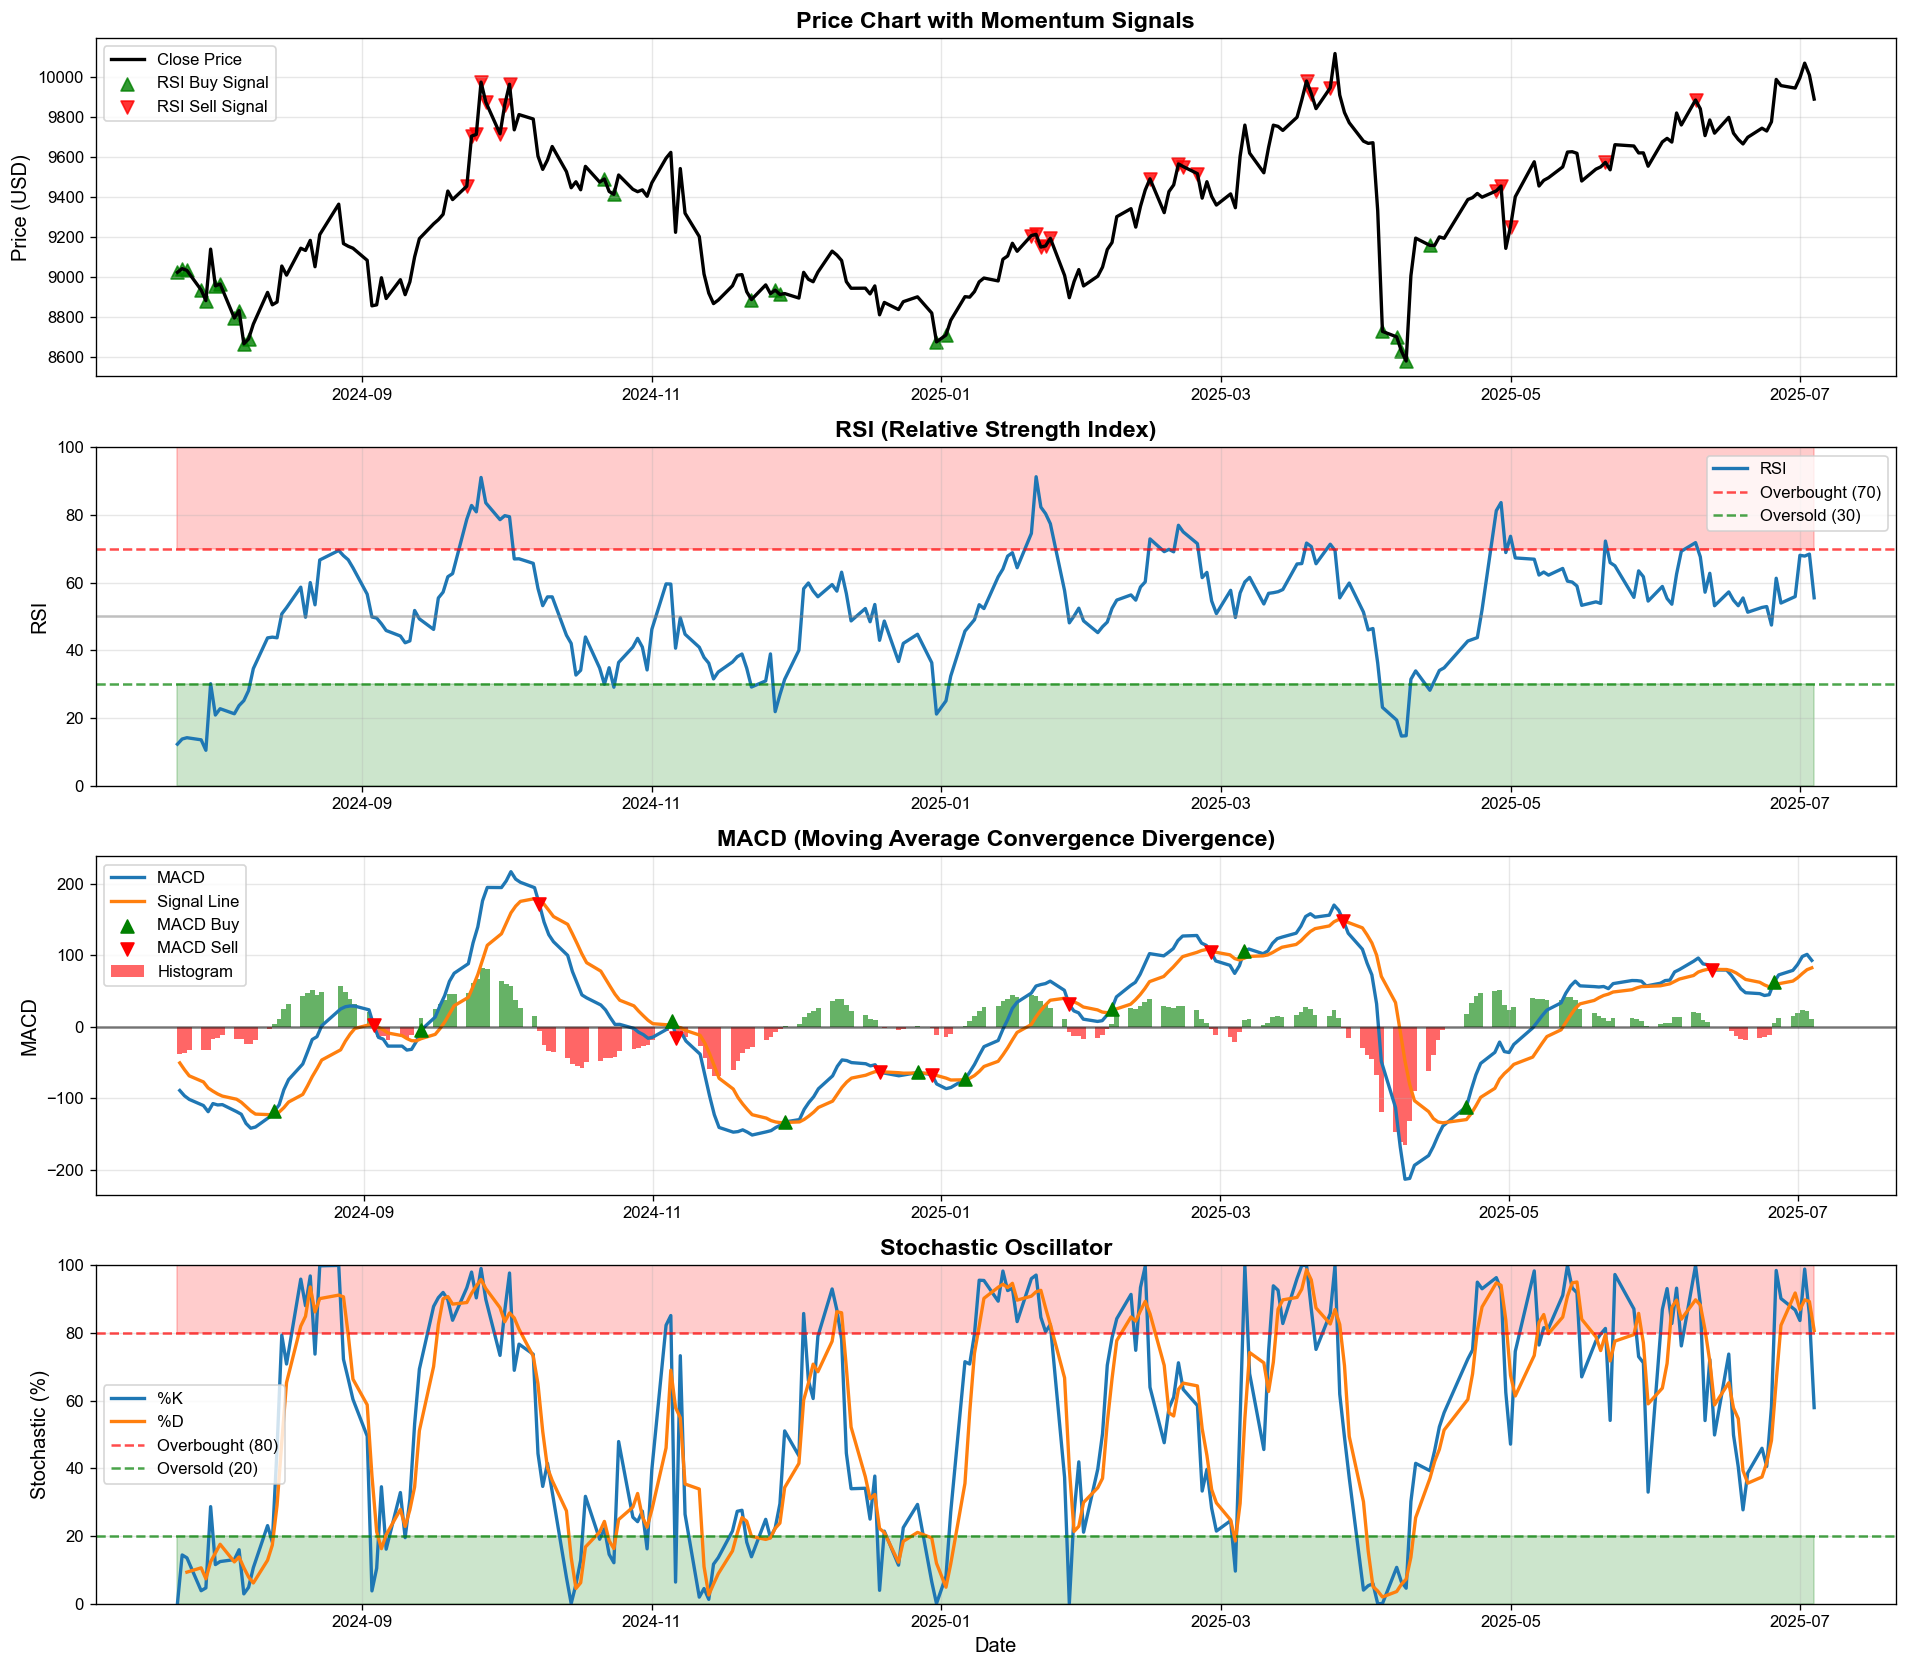


📊 モメンタム分析結果:
RSI: 55.5 (中立)
MACD: 92.82, シグナル: 82.46
MACDトレンド: 上昇モメンタム
ストキャスティクス %K: 58.0, %D: 80.7

統合シグナル: 買い1個, 売り0個
総合判定: 買いシグナル優勢


In [ ]:
# モメンタム分析
if 'RSI' in tech_data.columns and len(tech_data.dropna(subset=['RSI', 'MACD'])) > 20:

    momentum_data = tech_data.dropna(subset=['RSI', 'MACD', 'Stoch_K']).copy()

    if len(momentum_data) > 0:
        print(
            f"モメンタム分析対象期間: {momentum_data['TradeDate'].min().date()} - {momentum_data['TradeDate'].max().date()}")

        # モメンタムシグナルの検出
        momentum_data['RSI_Signal'] = 0
        momentum_data['MACD_Signal_Cross'] = 0

        # RSIシグナル
        momentum_data.loc[momentum_data['RSI']
                          > 70, 'RSI_Signal'] = -1  # 売りシグナル
        momentum_data.loc[momentum_data['RSI']
                          < 30, 'RSI_Signal'] = 1   # 買いシグナル

        # MACDシグナルクロス
        for i in range(1, len(momentum_data)):
            if (momentum_data.iloc[i]['MACD'] > momentum_data.iloc[i]['MACD_Signal'] and
                    momentum_data.iloc[i-1]['MACD'] <= momentum_data.iloc[i-1]['MACD_Signal']):
                momentum_data.iloc[i, momentum_data.columns.get_loc(
                    'MACD_Signal_Cross')] = 1
            elif (momentum_data.iloc[i]['MACD'] < momentum_data.iloc[i]['MACD_Signal'] and
                  momentum_data.iloc[i-1]['MACD'] >= momentum_data.iloc[i-1]['MACD_Signal']):
                momentum_data.iloc[i, momentum_data.columns.get_loc(
                    'MACD_Signal_Cross')] = -1

        # 可視化
        fig, axes = plt.subplots(4, 1, figsize=(16, 14))

        # 1. 価格チャート
        axes[0].plot(momentum_data['TradeDate'], momentum_data['ClosePrice'],
                     linewidth=2, color='black', label='Close Price')

        # RSIシグナルをマーク
        rsi_buy = momentum_data[momentum_data['RSI_Signal'] == 1]
        rsi_sell = momentum_data[momentum_data['RSI_Signal'] == -1]

        if len(rsi_buy) > 0:
            axes[0].scatter(rsi_buy['TradeDate'], rsi_buy['ClosePrice'],
                            color='green', s=60, marker='^', label='RSI Buy Signal', alpha=0.8)

        if len(rsi_sell) > 0:
            axes[0].scatter(rsi_sell['TradeDate'], rsi_sell['ClosePrice'],
                            color='red', s=60, marker='v', label='RSI Sell Signal', alpha=0.8)

        axes[0].set_title('Price Chart with Momentum Signals',
                          fontsize=14, weight='bold')
        axes[0].set_ylabel('Price (USD)', fontsize=12)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # 2. RSI
        axes[1].plot(momentum_data['TradeDate'], momentum_data['RSI'],
                     linewidth=2, color=COLORS['primary'], label='RSI')
        axes[1].axhline(y=70, color='red', linestyle='--',
                        alpha=0.7, label='Overbought (70)')
        axes[1].axhline(y=30, color='green', linestyle='--',
                        alpha=0.7, label='Oversold (30)')
        axes[1].axhline(y=50, color='gray', linestyle='-', alpha=0.5)

        # RSI危険エリアをハイライト
        axes[1].fill_between(momentum_data['TradeDate'],
                             70, 100, alpha=0.2, color='red')
        axes[1].fill_between(momentum_data['TradeDate'],
                             0, 30, alpha=0.2, color='green')

        axes[1].set_title('RSI (Relative Strength Index)',
                          fontsize=14, weight='bold')
        axes[1].set_ylabel('RSI', fontsize=12)
        axes[1].set_ylim(0, 100)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # 3. MACD
        axes[2].plot(momentum_data['TradeDate'], momentum_data['MACD'],
                     linewidth=2, color=COLORS['primary'], label='MACD')
        axes[2].plot(momentum_data['TradeDate'], momentum_data['MACD_Signal'],
                     linewidth=2, color=COLORS['secondary'], label='Signal Line')

        # MACDヒストグラム
        colors = ['green' if x >
                  0 else 'red' for x in momentum_data['MACD_Histogram']]
        axes[2].bar(momentum_data['TradeDate'], momentum_data['MACD_Histogram'],
                    color=colors, alpha=0.6, width=1, label='Histogram')

        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # MACDシグナルクロスをマーク
        macd_buy = momentum_data[momentum_data['MACD_Signal_Cross'] == 1]
        macd_sell = momentum_data[momentum_data['MACD_Signal_Cross'] == -1]

        if len(macd_buy) > 0:
            axes[2].scatter(macd_buy['TradeDate'], macd_buy['MACD'],
                            color='green', s=60, marker='^', label='MACD Buy', zorder=5)

        if len(macd_sell) > 0:
            axes[2].scatter(macd_sell['TradeDate'], macd_sell['MACD'],
                            color='red', s=60, marker='v', label='MACD Sell', zorder=5)

        axes[2].set_title(
            'MACD (Moving Average Convergence Divergence)', fontsize=14, weight='bold')
        axes[2].set_ylabel('MACD', fontsize=12)
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        # 4. ストキャスティクス
        axes[3].plot(momentum_data['TradeDate'], momentum_data['Stoch_K'],
                     linewidth=2, color=COLORS['primary'], label='%K')
        axes[3].plot(momentum_data['TradeDate'], momentum_data['Stoch_D'],
                     linewidth=2, color=COLORS['secondary'], label='%D')

        axes[3].axhline(y=80, color='red', linestyle='--',
                        alpha=0.7, label='Overbought (80)')
        axes[3].axhline(y=20, color='green', linestyle='--',
                        alpha=0.7, label='Oversold (20)')

        # ストキャス危険エリア
        axes[3].fill_between(momentum_data['TradeDate'],
                             80, 100, alpha=0.2, color='red')
        axes[3].fill_between(momentum_data['TradeDate'],
                             0, 20, alpha=0.2, color='green')

        axes[3].set_title('Stochastic Oscillator', fontsize=14, weight='bold')
        axes[3].set_ylabel('Stochastic (%)', fontsize=12)
        axes[3].set_xlabel('Date', fontsize=12)
        axes[3].set_ylim(0, 100)
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 現在の状況分析
        current = momentum_data.iloc[-1]
        print("\n📊 モメンタム分析結果:")
        print(f"RSI: {current['RSI']:.1f} ", end="")
        if current['RSI'] > 70:
            print("(買われ過ぎ)")
        elif current['RSI'] < 30:
            print("(売られ過ぎ)")
        else:
            print("(中立)")

        print(
            f"MACD: {current['MACD']:.2f}, シグナル: {current['MACD_Signal']:.2f}")
        if current['MACD'] > current['MACD_Signal']:
            print("MACDトレンド: 上昇モメンタム")
        else:
            print("MACDトレンド: 下降モメンタム")

        print(
            f"ストキャスティクス %K: {current['Stoch_K']:.1f}, %D: {current['Stoch_D']:.1f}")

        # 統合シグナル
        buy_signals = 0
        sell_signals = 0

        if current['RSI'] < 30:
            buy_signals += 1
        elif current['RSI'] > 70:
            sell_signals += 1

        if current['MACD'] > current['MACD_Signal']:
            buy_signals += 1
        else:
            sell_signals += 1

        if current['Stoch_K'] < 20:
            buy_signals += 1
        elif current['Stoch_K'] > 80:
            sell_signals += 1

        print(f"\n統合シグナル: 買い{buy_signals}個, 売り{sell_signals}個")

        if buy_signals > sell_signals:
            print("総合判定: 買いシグナル優勢")
        elif sell_signals > buy_signals:
            print("総合判定: 売りシグナル優勢")
        else:
            print("総合判定: 中立")

    else:
        print("モメンタム分析に十分なクリーンなデータがありません")
else:
    print("モメンタム指標計算に十分なデータがありません")

## 3. ボラティリティとサポート・レジスタンス分析

### 分析目的
価格の変動性を測定し、重要なサポート・レジスタンス水準を特定して、エントリー・エグジットポイントの判断材料を提供します。

### 分析手法
- **ボリンジャーバンド**: 価格の正常範囲と異常値の検出
- **ATR (Average True Range)**: ボラティリティの定量化
- **価格レンジ分析**: 高値・安値の分布
- **サポート・レジスタンス**: 重要な価格水準の自動検出

### グラフの見方・解釈
- **ボリンジャーバンド上限タッチ**: 売りを検討
- **ボリンジャーバンド下限タッチ**: 買いを検討
- **バンド幅拡大**: ボラティリティ増加、大きな動きの可能性
- **バンド幅収束**: ボラティリティ低下、ブレイクアウト待ち
- **サポート・レジスタンス**: 価格の反転ポイント

ボラティリティ分析対象期間: 2024-08-01 - 2025-07-04


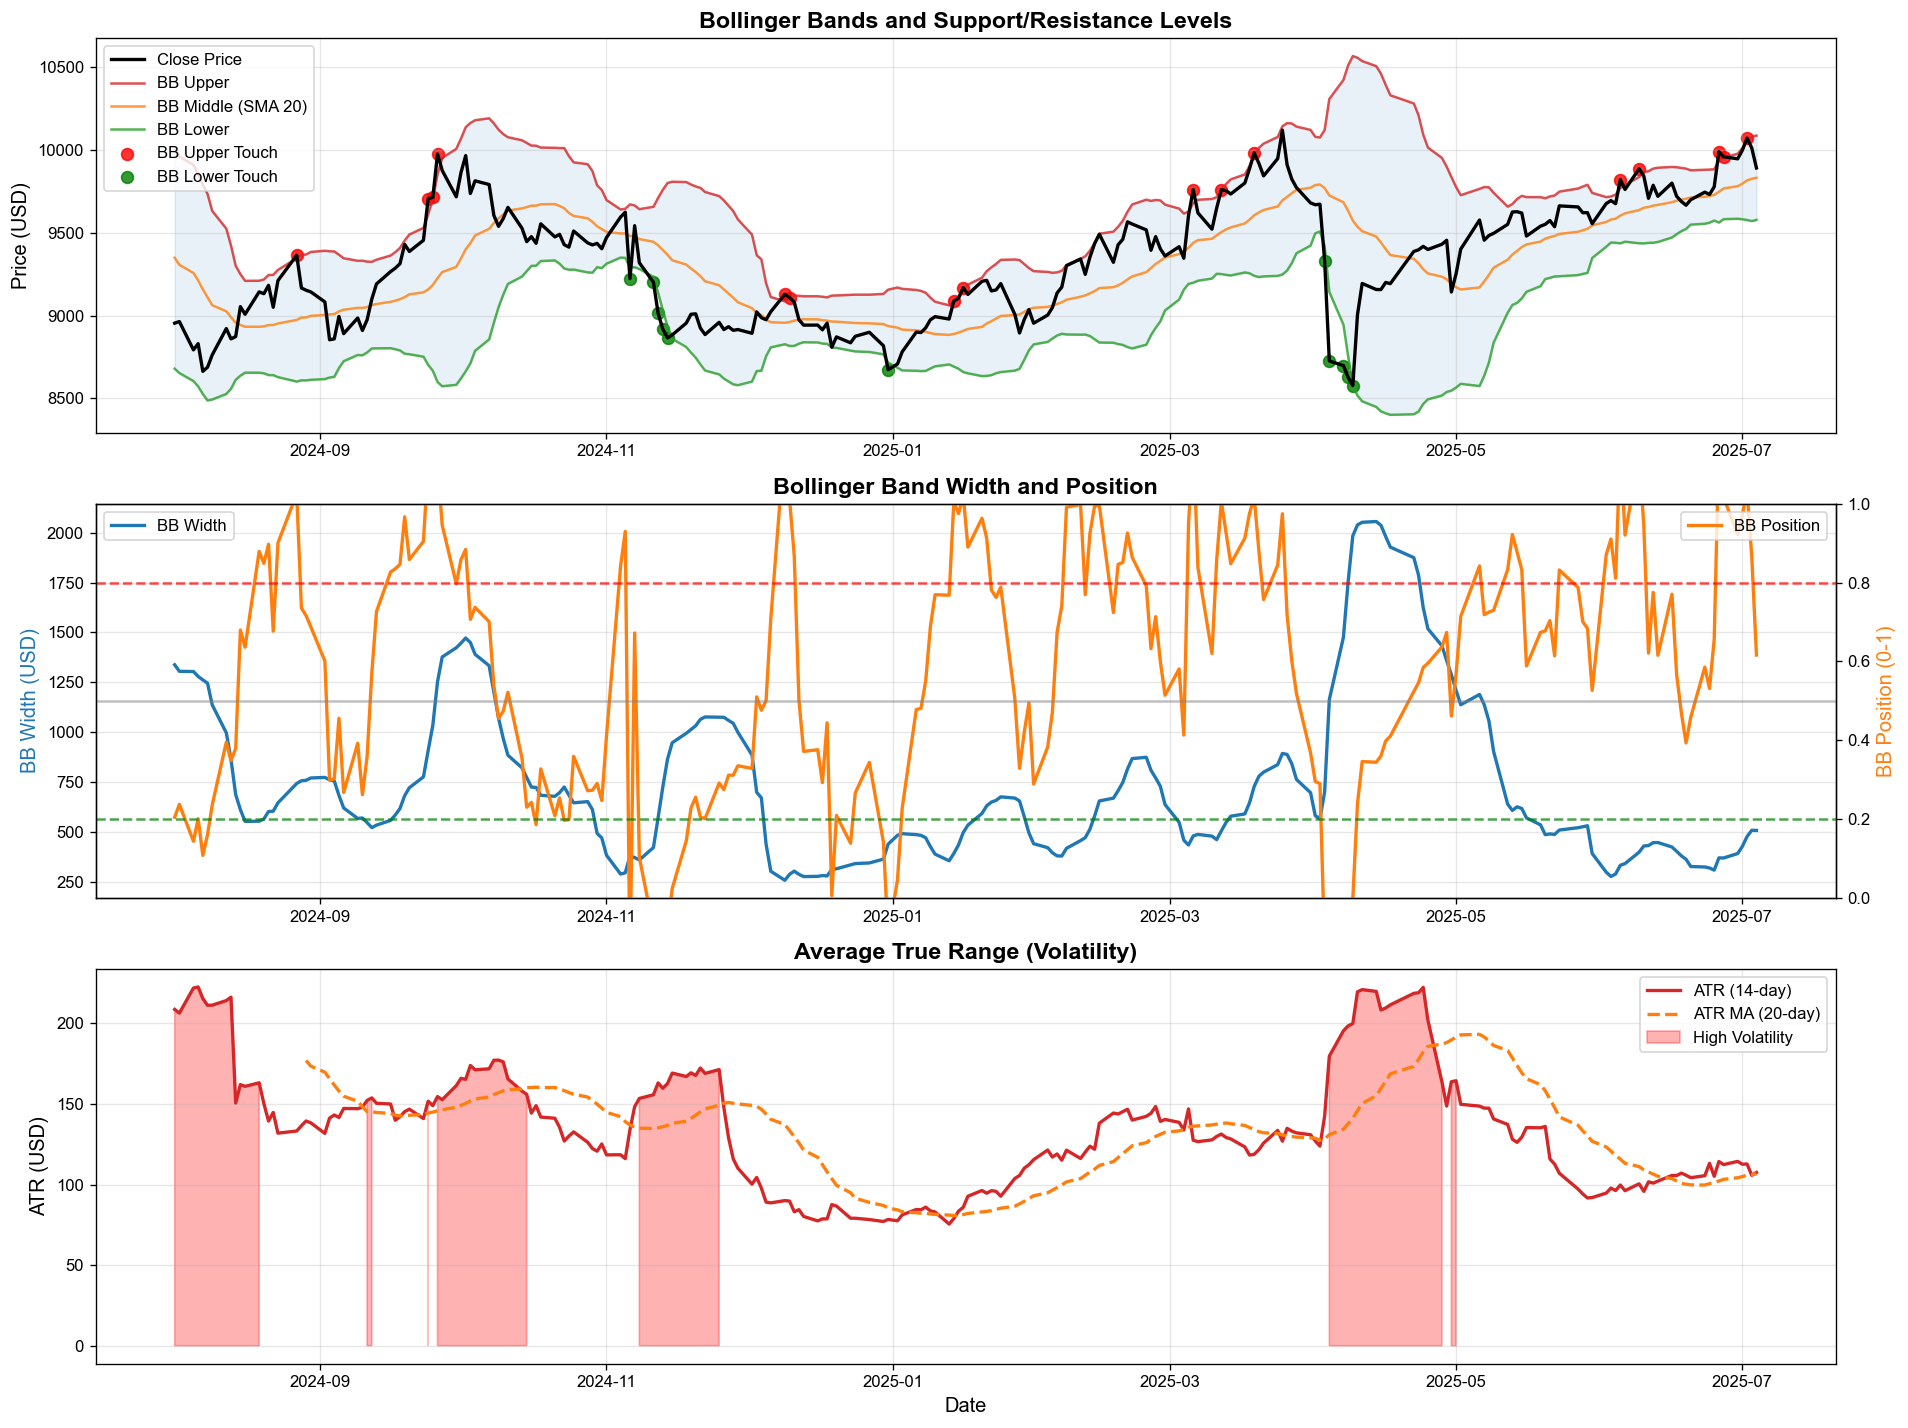


📈 ボラティリティ・サポレジ分析結果:
現在価格: $9890.00
ボリンジャーバンド: $9576.60 - $10085.24
BB位置: 0.62 (0=下限, 1=上限)
BB幅: $508.64
ATR: $107.47
ATRパーセンタイル: 27% (過去データ中の位置)
ボラティリティ状況: 中程度ボラティリティ
BBシグナル: 中立（バンド中央付近）


In [ ]:
# ボラティリティとサポート・レジスタンス分析
if 'BB_Upper' in tech_data.columns and len(tech_data.dropna(subset=['BB_Upper', 'ATR'])) > 20:

    volatility_data = tech_data.dropna(
        subset=['BB_Upper', 'BB_Lower', 'ATR']).copy()

    if len(volatility_data) > 0:
        print(
            f"ボラティリティ分析対象期間: {volatility_data['TradeDate'].min().date()} - {volatility_data['TradeDate'].max().date()}")

        # サポート・レジスタンスの自動検出
        def find_support_resistance(data, window=10, threshold=0.02):
            """
            サポート・レジスタンス水準を自動検出
            """
            highs = data['HighPrice'].values
            lows = data['LowPrice'].values

            # ピークとボトムを検出
            try:
                high_peaks, _ = find_peaks(highs, distance=window)
                low_peaks, _ = find_peaks(-lows, distance=window)

                resistance_levels = highs[high_peaks]
                support_levels = lows[low_peaks]

                # 重要な水準をフィルタリング（複数回テストされた水準）
                resistance_counts = {}
                support_counts = {}

                for level in resistance_levels:
                    key = round(level / (level * threshold)) * \
                        (level * threshold)
                    resistance_counts[key] = resistance_counts.get(key, 0) + 1

                for level in support_levels:
                    key = round(level / (level * threshold)) * \
                        (level * threshold)
                    support_counts[key] = support_counts.get(key, 0) + 1

                # 2回以上テストされた水準のみ採用
                strong_resistance = [
                    k for k, v in resistance_counts.items() if v >= 2]
                strong_support = [
                    k for k, v in support_counts.items() if v >= 2]

                return strong_support, strong_resistance

            except:
                return [], []

        support_levels, resistance_levels = find_support_resistance(
            volatility_data)

        # ボリンジャーバンドのタッチ検出
        volatility_data['BB_Touch'] = 0
        volatility_data.loc[volatility_data['ClosePrice'] >=
                            volatility_data['BB_Upper'], 'BB_Touch'] = 1  # 上限タッチ
        volatility_data.loc[volatility_data['ClosePrice'] <=
                            volatility_data['BB_Lower'], 'BB_Touch'] = -1  # 下限タッチ

        # 可視化
        fig, axes = plt.subplots(3, 1, figsize=(16, 12))

        # 1. 価格とボリンジャーバンド
        axes[0].plot(volatility_data['TradeDate'], volatility_data['ClosePrice'],
                     linewidth=2, color='black', label='Close Price', zorder=3)
        axes[0].plot(volatility_data['TradeDate'], volatility_data['BB_Upper'],
                     linewidth=1.5, color=COLORS['quaternary'], label='BB Upper', alpha=0.8)
        axes[0].plot(volatility_data['TradeDate'], volatility_data['BB_Middle'],
                     linewidth=1.5, color=COLORS['secondary'], label='BB Middle (SMA 20)', alpha=0.8)
        axes[0].plot(volatility_data['TradeDate'], volatility_data['BB_Lower'],
                     linewidth=1.5, color=COLORS['tertiary'], label='BB Lower', alpha=0.8)

        # ボリンジャーバンドの塗りつぶし
        axes[0].fill_between(volatility_data['TradeDate'],
                             volatility_data['BB_Upper'], volatility_data['BB_Lower'],
                             alpha=0.1, color=COLORS['primary'])

        # ボリンジャーバンドタッチをマーク
        bb_upper_touch = volatility_data[volatility_data['BB_Touch'] == 1]
        bb_lower_touch = volatility_data[volatility_data['BB_Touch'] == -1]

        if len(bb_upper_touch) > 0:
            axes[0].scatter(bb_upper_touch['TradeDate'], bb_upper_touch['ClosePrice'],
                            color='red', s=50, marker='o', label='BB Upper Touch', alpha=0.8)

        if len(bb_lower_touch) > 0:
            axes[0].scatter(bb_lower_touch['TradeDate'], bb_lower_touch['ClosePrice'],
                            color='green', s=50, marker='o', label='BB Lower Touch', alpha=0.8)

        # サポート・レジスタンス水準
        for level in resistance_levels[-3:]:  # 最新の3つの水準のみ表示
            axes[0].axhline(y=level, color='red',
                            linestyle='--', alpha=0.6, linewidth=1)
            axes[0].text(volatility_data['TradeDate'].iloc[-1], level, f'R: ${level:.0f}',
                         color='red', fontsize=9, ha='left')

        for level in support_levels[-3:]:  # 最新の3つの水準のみ表示
            axes[0].axhline(y=level, color='green',
                            linestyle='--', alpha=0.6, linewidth=1)
            axes[0].text(volatility_data['TradeDate'].iloc[-1], level, f'S: ${level:.0f}',
                         color='green', fontsize=9, ha='left')

        axes[0].set_title(
            'Bollinger Bands and Support/Resistance Levels', fontsize=14, weight='bold')
        axes[0].set_ylabel('Price (USD)', fontsize=12)
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        # 2. ボリンジャーバンド幅とポジション
        ax2_twin = axes[1].twinx()

        axes[1].plot(volatility_data['TradeDate'], volatility_data['BB_Width'],
                     linewidth=2, color=COLORS['primary'], label='BB Width')
        ax2_twin.plot(volatility_data['TradeDate'], volatility_data['BB_Position'],
                      linewidth=2, color=COLORS['secondary'], label='BB Position')

        ax2_twin.axhline(y=0.8, color='red', linestyle='--', alpha=0.7)
        ax2_twin.axhline(y=0.2, color='green', linestyle='--', alpha=0.7)
        ax2_twin.axhline(y=0.5, color='gray', linestyle='-', alpha=0.5)

        axes[1].set_title('Bollinger Band Width and Position',
                          fontsize=14, weight='bold')
        axes[1].set_ylabel('BB Width (USD)', fontsize=12,
                           color=COLORS['primary'])
        ax2_twin.set_ylabel('BB Position (0-1)', fontsize=12,
                            color=COLORS['secondary'])
        ax2_twin.set_ylim(0, 1)

        axes[1].legend(loc='upper left')
        ax2_twin.legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)

        # 3. ATR (ボラティリティ)
        axes[2].plot(volatility_data['TradeDate'], volatility_data['ATR'],
                     linewidth=2, color=COLORS['quaternary'], label='ATR (14-day)')

        # ATRの移動平均
        atr_ma = volatility_data['ATR'].rolling(window=20).mean()
        axes[2].plot(volatility_data['TradeDate'], atr_ma,
                     linewidth=2, color=COLORS['secondary'], label='ATR MA (20-day)', linestyle='--')

        # 高ボラティリティ期間をハイライト
        high_vol_threshold = atr_ma.quantile(0.75) if len(
            atr_ma.dropna()) > 0 else volatility_data['ATR'].quantile(0.75)
        high_vol_periods = volatility_data['ATR'] > high_vol_threshold

        axes[2].fill_between(volatility_data['TradeDate'], 0, volatility_data['ATR'],
                             where=high_vol_periods, alpha=0.3, color='red', label='High Volatility')

        axes[2].set_title('Average True Range (Volatility)',
                          fontsize=14, weight='bold')
        axes[2].set_ylabel('ATR (USD)', fontsize=12)
        axes[2].set_xlabel('Date', fontsize=12)
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 分析結果サマリー
        current = volatility_data.iloc[-1]
        print("\n📈 ボラティリティ・サポレジ分析結果:")
        print(f"現在価格: ${current['ClosePrice']:.2f}")
        print(
            f"ボリンジャーバンド: ${current['BB_Lower']:.2f} - ${current['BB_Upper']:.2f}")
        print(f"BB位置: {current['BB_Position']:.2f} (0=下限, 1=上限)")
        print(f"BB幅: ${current['BB_Width']:.2f}")
        print(f"ATR: ${current['ATR']:.2f}")

        # ボラティリティ評価
        atr_percentile = (
            volatility_data['ATR'] <= current['ATR']).mean() * 100
        print(f"ATRパーセンタイル: {atr_percentile:.0f}% (過去データ中の位置)")

        if atr_percentile > 75:
            vol_status = "高ボラティリティ"
        elif atr_percentile < 25:
            vol_status = "低ボラティリティ"
        else:
            vol_status = "中程度ボラティリティ"

        print(f"ボラティリティ状況: {vol_status}")

        # サポート・レジスタンス
        if len(resistance_levels) > 0:
            nearest_resistance = min(
                resistance_levels, key=lambda x: abs(x - current['ClosePrice']))
            print(
                f"最寄りレジスタンス: ${nearest_resistance:.2f} (現在価格からの距離: {((nearest_resistance/current['ClosePrice']-1)*100):+.2f}%)")

        if len(support_levels) > 0:
            nearest_support = min(
                support_levels, key=lambda x: abs(x - current['ClosePrice']))
            print(
                f"最寄りサポート: ${nearest_support:.2f} (現在価格からの距離: {((nearest_support/current['ClosePrice']-1)*100):+.2f}%)")

        # ボリンジャーバンド分析
        if current['BB_Position'] > 0.8:
            bb_signal = "売りを検討（上限近辺）"
        elif current['BB_Position'] < 0.2:
            bb_signal = "買いを検討（下限近辺）"
        else:
            bb_signal = "中立（バンド中央付近）"

        print(f"BBシグナル: {bb_signal}")

    else:
        print("ボラティリティ分析に十分なクリーンなデータがありません")
else:
    print("ボラティリティ指標計算に十分なデータがありません")

## 4. トレンド強度とADX分析

### 分析目的
ADX（Average Directional Index）を使用してトレンドの強度を定量化し、トレンドフォロー戦略の有効性を判断します。

### 分析手法
- **ADX**: トレンド強度の測定（方向性を問わない）
- **+DI / -DI**: 上昇・下降の方向性指標
- **DX**: 方向性の明確度
- **トレンド分類**: ADX値による市場状況の分類

### グラフの見方・解釈
- **ADX > 25**: 強いトレンド → トレンドフォロー戦略有効
- **ADX < 20**: 弱いトレンド・レンジ相場 → 逆張り戦略検討
- **+DI > -DI**: 上昇トレンド
- **-DI > +DI**: 下降トレンド
- **DI線のクロス**: トレンド転換のシグナル

ADX分析対象期間: 2024-08-12 - 2025-07-04


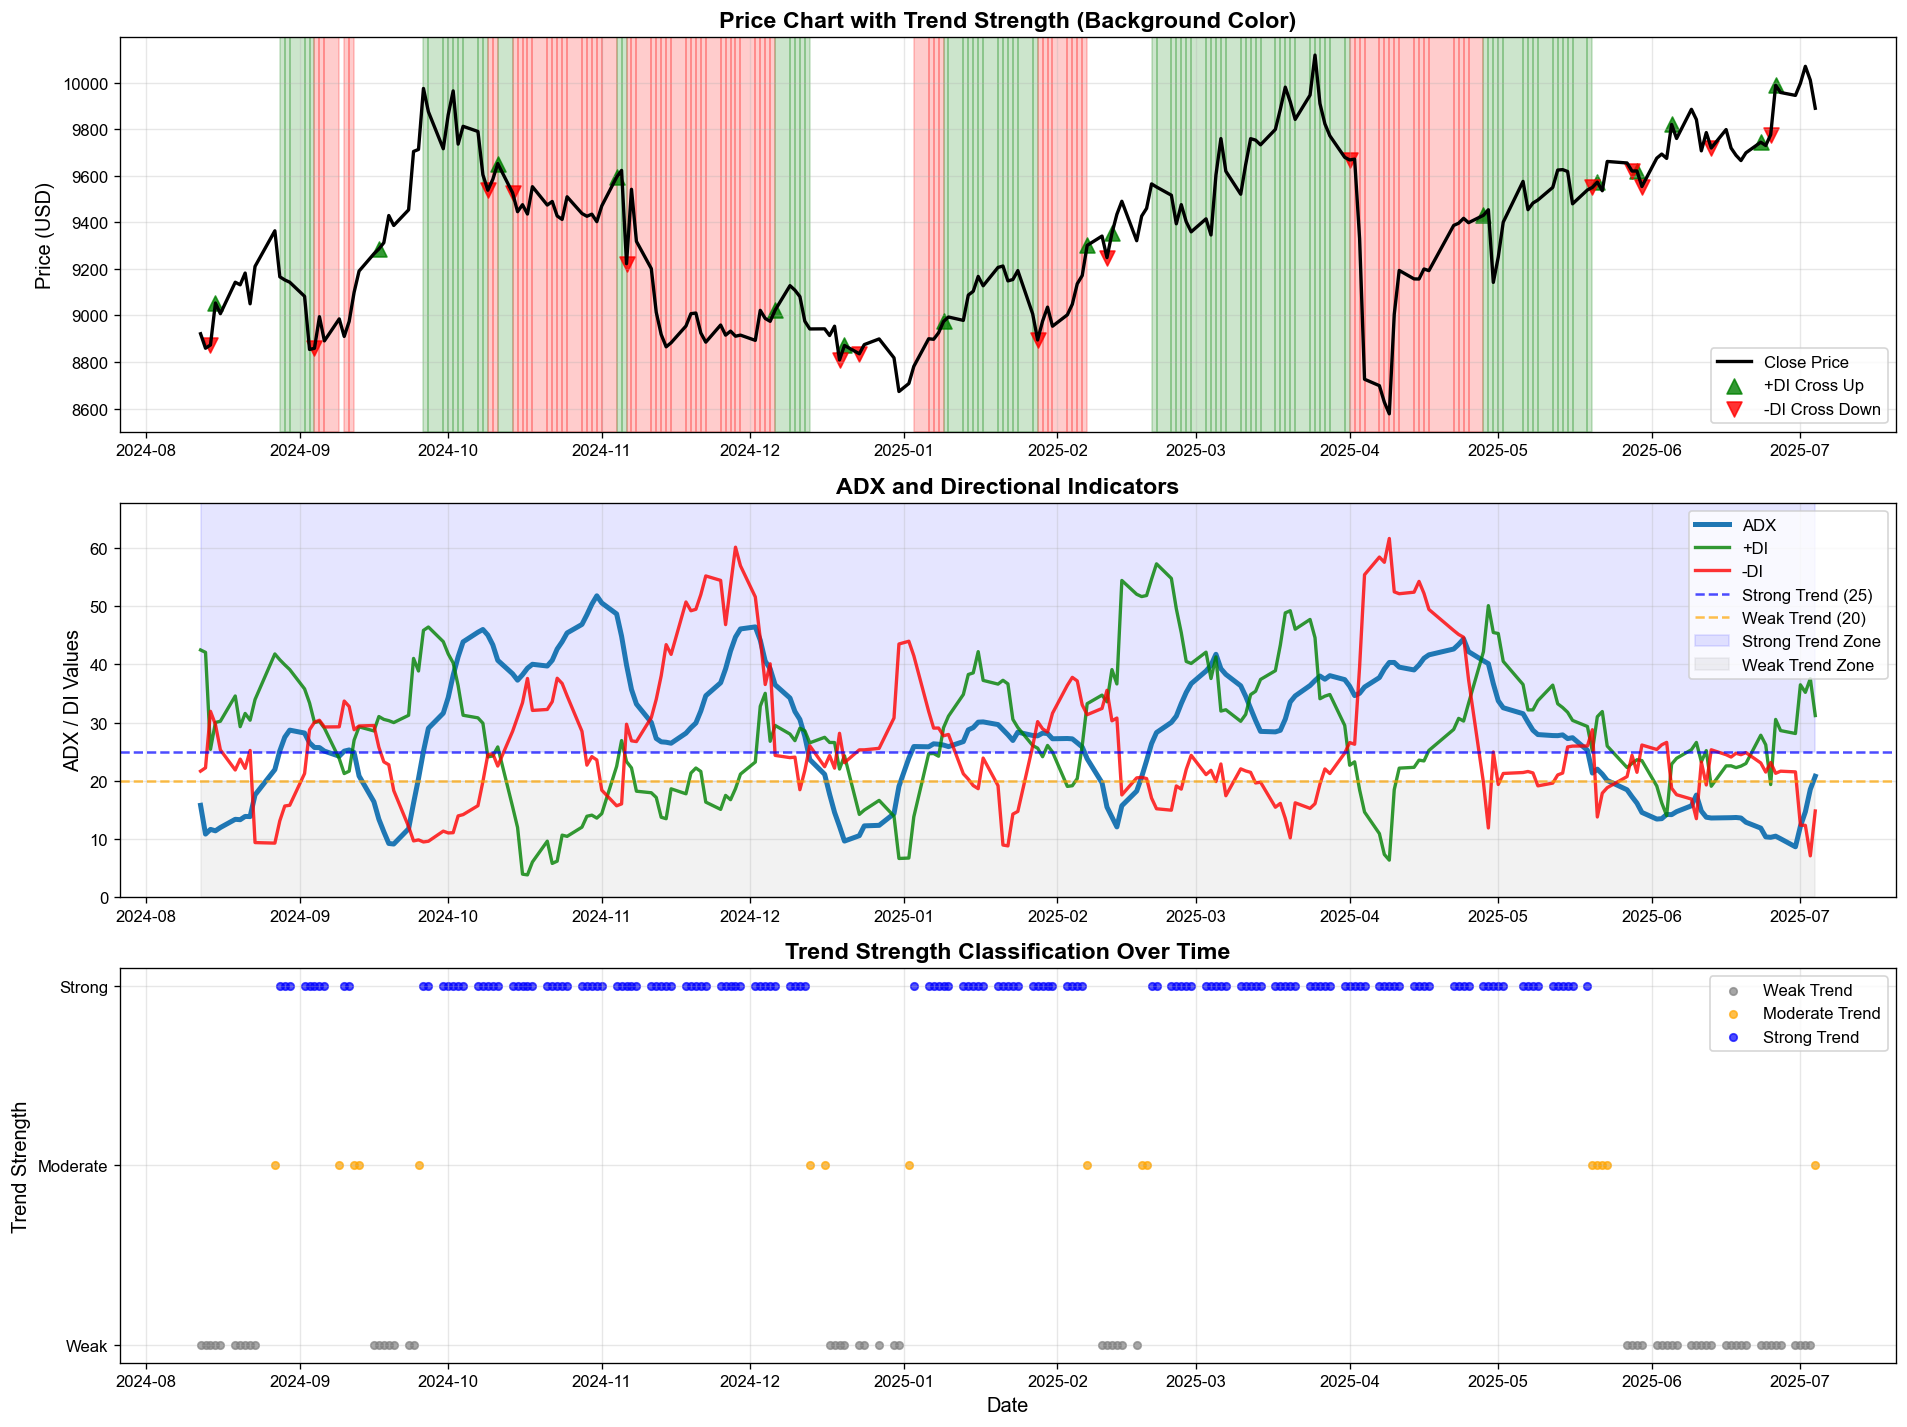


📊 ADXトレンド強度分析結果:
ADX: 20.8
+DI: 31.2
-DI: 14.8
トレンド強度: Moderate
トレンド方向: Up

トレンド強度分布:
  Strong: 151日 (66.5%)
  Weak: 60日 (26.4%)
  Moderate: 16日 (7.0%)

推奨戦略: 中程度トレンド - 慎重なポジション取り推奨


In [ ]:
# ADXトレンド強度分析
if 'ADX' in tech_data.columns and len(tech_data.dropna(subset=['ADX'])) > 20:

    adx_data = tech_data.dropna(subset=['ADX', 'DI_Plus', 'DI_Minus']).copy()

    if len(adx_data) > 0:
        print(
            f"ADX分析対象期間: {adx_data['TradeDate'].min().date()} - {adx_data['TradeDate'].max().date()}")

        # トレンド強度の分類
        adx_data['Trend_Strength'] = 'Weak'
        adx_data.loc[adx_data['ADX'] >= 25, 'Trend_Strength'] = 'Strong'
        adx_data.loc[(adx_data['ADX'] >= 20) & (
            adx_data['ADX'] < 25), 'Trend_Strength'] = 'Moderate'

        # トレンド方向
        adx_data['Trend_Direction'] = 'Neutral'
        adx_data.loc[adx_data['DI_Plus'] >
                     adx_data['DI_Minus'], 'Trend_Direction'] = 'Up'
        adx_data.loc[adx_data['DI_Plus'] <
                     adx_data['DI_Minus'], 'Trend_Direction'] = 'Down'

        # DIクロスシグナル
        adx_data['DI_Cross'] = 0
        for i in range(1, len(adx_data)):
            if (adx_data.iloc[i]['DI_Plus'] > adx_data.iloc[i]['DI_Minus'] and
                    adx_data.iloc[i-1]['DI_Plus'] <= adx_data.iloc[i-1]['DI_Minus']):
                adx_data.iloc[i, adx_data.columns.get_loc(
                    'DI_Cross')] = 1  # 上昇転換
            elif (adx_data.iloc[i]['DI_Plus'] < adx_data.iloc[i]['DI_Minus'] and
                  adx_data.iloc[i-1]['DI_Plus'] >= adx_data.iloc[i-1]['DI_Minus']):
                adx_data.iloc[i, adx_data.columns.get_loc(
                    'DI_Cross')] = -1  # 下降転換

        # 可視化
        fig, axes = plt.subplots(3, 1, figsize=(16, 12))

        # 1. 価格チャートとトレンド強度
        axes[0].plot(adx_data['TradeDate'], adx_data['ClosePrice'],
                     linewidth=2, color='black', label='Close Price')

        # トレンド強度による背景色
        strong_trend = adx_data['Trend_Strength'] == 'Strong'
        moderate_trend = adx_data['Trend_Strength'] == 'Moderate'

        # 強いトレンド期間をハイライト
        for i, is_strong in enumerate(strong_trend):
            if is_strong:
                color = 'green' if adx_data.iloc[i]['Trend_Direction'] == 'Up' else 'red'
                axes[0].axvspan(adx_data.iloc[i]['TradeDate'],
                                adx_data.iloc[min(
                                    i+1, len(adx_data)-1)]['TradeDate'],
                                alpha=0.2, color=color)

        # DIクロスシグナル
        di_up_cross = adx_data[adx_data['DI_Cross'] == 1]
        di_down_cross = adx_data[adx_data['DI_Cross'] == -1]

        if len(di_up_cross) > 0:
            axes[0].scatter(di_up_cross['TradeDate'], di_up_cross['ClosePrice'],
                            color='green', s=80, marker='^', label='+DI Cross Up', alpha=0.8)

        if len(di_down_cross) > 0:
            axes[0].scatter(di_down_cross['TradeDate'], di_down_cross['ClosePrice'],
                            color='red', s=80, marker='v', label='-DI Cross Down', alpha=0.8)

        axes[0].set_title(
            'Price Chart with Trend Strength (Background Color)', fontsize=14, weight='bold')
        axes[0].set_ylabel('Price (USD)', fontsize=12)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # 2. ADXとDI指標
        axes[1].plot(adx_data['TradeDate'], adx_data['ADX'],
                     linewidth=3, color=COLORS['primary'], label='ADX')
        axes[1].plot(adx_data['TradeDate'], adx_data['DI_Plus'],
                     linewidth=2, color='green', label='+DI', alpha=0.8)
        axes[1].plot(adx_data['TradeDate'], adx_data['DI_Minus'],
                     linewidth=2, color='red', label='-DI', alpha=0.8)

        # ADX閾値ライン
        axes[1].axhline(y=25, color='blue', linestyle='--',
                        alpha=0.7, label='Strong Trend (25)')
        axes[1].axhline(y=20, color='orange', linestyle='--',
                        alpha=0.7, label='Weak Trend (20)')

        # トレンド強度エリア
        axes[1].fill_between(adx_data['TradeDate'], 25, 100,
                             alpha=0.1, color='blue', label='Strong Trend Zone')
        axes[1].fill_between(adx_data['TradeDate'], 0, 20,
                             alpha=0.1, color='gray', label='Weak Trend Zone')

        axes[1].set_title('ADX and Directional Indicators',
                          fontsize=14, weight='bold')
        axes[1].set_ylabel('ADX / DI Values', fontsize=12)
        axes[1].set_ylim(
            0, max(adx_data[['ADX', 'DI_Plus', 'DI_Minus']].max()) * 1.1)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # 3. トレンド強度分布とタイムライン
        # トレンド強度の時系列表示
        trend_numeric = adx_data['Trend_Strength'].map(
            {'Weak': 0, 'Moderate': 1, 'Strong': 2})

        colors_map = {'Weak': 'gray', 'Moderate': 'orange', 'Strong': 'blue'}
        for strength in ['Weak', 'Moderate', 'Strong']:
            mask = adx_data['Trend_Strength'] == strength
            if mask.sum() > 0:
                axes[2].scatter(adx_data.loc[mask, 'TradeDate'],
                                trend_numeric[mask],
                                c=colors_map[strength], s=20, alpha=0.7, label=f'{strength} Trend')

        axes[2].set_title(
            'Trend Strength Classification Over Time', fontsize=14, weight='bold')
        axes[2].set_ylabel('Trend Strength', fontsize=12)
        axes[2].set_xlabel('Date', fontsize=12)
        axes[2].set_yticks([0, 1, 2])
        axes[2].set_yticklabels(['Weak', 'Moderate', 'Strong'])
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # ADX分析結果
        current = adx_data.iloc[-1]
        print("\n📊 ADXトレンド強度分析結果:")
        print(f"ADX: {current['ADX']:.1f}")
        print(f"+DI: {current['DI_Plus']:.1f}")
        print(f"-DI: {current['DI_Minus']:.1f}")
        print(f"トレンド強度: {current['Trend_Strength']}")
        print(f"トレンド方向: {current['Trend_Direction']}")

        # トレンド強度の統計
        trend_counts = adx_data['Trend_Strength'].value_counts()
        print("\nトレンド強度分布:")
        for strength, count in trend_counts.items():
            percentage = count / len(adx_data) * 100
            print(f"  {strength}: {count}日 ({percentage:.1f}%)")

        # 戦略提案
        if current['ADX'] >= 25:
            if current['DI_Plus'] > current['DI_Minus']:
                strategy = "強い上昇トレンド - トレンドフォロー（買い）戦略推奨"
            else:
                strategy = "強い下降トレンド - トレンドフォロー（売り）戦略推奨"
        elif current['ADX'] < 20:
            strategy = "弱いトレンド・レンジ相場 - 逆張り戦略や様子見推奨"
        else:
            strategy = "中程度トレンド - 慎重なポジション取り推奨"

        print(f"\n推奨戦略: {strategy}")

    else:
        print("ADX分析に十分なクリーンなデータがありません")
else:
    print("ADX指標計算に十分なデータがありません")

## 5. 総合トレンド分析サマリー

### 分析結果の統合
ここまでの各種トレンド分析結果を統合し、総合的な市場判断と投資戦略を提示します。

### 評価項目
- **移動平均トレンド**: 短期・中期・長期の方向性
- **モメンタム指標**: RSI、MACD、ストキャスティクスの総合判定
- **ボラティリティ**: 現在の変動性と適切なポジションサイズ
- **トレンド強度**: ADXによる戦略の有効性判定
- **サポート・レジスタンス**: 重要な価格水準とリスク管理

### 投資戦略への応用
- **エントリー戦略**: 最適な参入タイミング
- **エグジット戦略**: 利益確定・損切りの目安
- **ポジションサイズ**: ボラティリティに応じた適切な投資規模
- **リスク管理**: ストップロス・テイクプロフィットの設定指針

In [ ]:
# 総合トレンド分析サマリー
if len(tech_data) > 60 and 'ADX' in tech_data.columns:

    # 最新データの取得
    latest_complete = tech_data.dropna(
        subset=['RSI', 'MACD', 'ADX', 'BB_Position']).iloc[-1]

    print("🎯 総合トレンド分析サマリー")
    print("=" * 50)

    # 現在の価格情報
    print(f"\n📊 現在の市場状況 ({latest_complete['TradeDate'].strftime('%Y-%m-%d')})")
    print(f"価格: ${latest_complete['ClosePrice']:.2f}")
    print(f"出来高: {latest_complete['Volume']:,.0f}")

    # 1. 移動平均分析スコア
    ma_score = 0
    ma_signals = []

    if 'SMA_10' in tech_data.columns and not pd.isna(latest_complete.get('SMA_10')):
        if latest_complete['ClosePrice'] > latest_complete['SMA_10']:
            ma_score += 1
            ma_signals.append("短期MA上向き")
        else:
            ma_score -= 1
            ma_signals.append("短期MA下向き")

    if 'SMA_20' in tech_data.columns and not pd.isna(latest_complete.get('SMA_20')):
        if latest_complete['ClosePrice'] > latest_complete['SMA_20']:
            ma_score += 1
            ma_signals.append("中期MA上向き")
        else:
            ma_score -= 1
            ma_signals.append("中期MA下向き")

    if 'SMA_50' in tech_data.columns and not pd.isna(latest_complete.get('SMA_50')):
        if latest_complete['ClosePrice'] > latest_complete['SMA_50']:
            ma_score += 1
            ma_signals.append("長期MA上向き")
        else:
            ma_score -= 1
            ma_signals.append("長期MA下向き")

    # 2. モメンタム分析スコア
    momentum_score = 0
    momentum_signals = []

    # RSI
    if not pd.isna(latest_complete.get('RSI')):
        if latest_complete['RSI'] > 70:
            momentum_score -= 1
            momentum_signals.append("RSI買われ過ぎ")
        elif latest_complete['RSI'] < 30:
            momentum_score += 1
            momentum_signals.append("RSI売られ過ぎ")
        else:
            momentum_signals.append("RSI中立")

    # MACD
    if not pd.isna(latest_complete.get('MACD')) and not pd.isna(latest_complete.get('MACD_Signal')):
        if latest_complete['MACD'] > latest_complete['MACD_Signal']:
            momentum_score += 1
            momentum_signals.append("MACD上昇")
        else:
            momentum_score -= 1
            momentum_signals.append("MACD下降")

    # 3. ボラティリティ分析
    volatility_status = "中程度"
    if 'ATR' in tech_data.columns:
        atr_data = tech_data['ATR'].dropna()
        if len(atr_data) > 0:
            current_atr = latest_complete.get('ATR', atr_data.iloc[-1])
            atr_percentile = (atr_data <= current_atr).mean() * 100

            if atr_percentile > 75:
                volatility_status = "高ボラティリティ"
            elif atr_percentile < 25:
                volatility_status = "低ボラティリティ"

    # 4. トレンド強度
    trend_strength = "不明"
    if not pd.isna(latest_complete.get('ADX')):
        adx_value = latest_complete['ADX']
        if adx_value >= 25:
            trend_strength = "強いトレンド"
        elif adx_value >= 20:
            trend_strength = "中程度トレンド"
        else:
            trend_strength = "弱いトレンド"

    # 総合スコアの計算
    total_score = ma_score + momentum_score

    # 結果表示
    print(f"\n📈 トレンド分析結果")
    print(f"移動平均スコア: {ma_score:+d}/3 ({', '.join(ma_signals)})")
    print(f"モメンタムスコア: {momentum_score:+d}/2 ({', '.join(momentum_signals)})")
    print(f"ボラティリティ: {volatility_status}")
    print(f"トレンド強度: {trend_strength}")

    # 総合判定
    print(f"\n🎯 総合スコア: {total_score:+d}")

    if total_score >= 2:
        overall_bias = "強気"
        strategy_color = "🟢"
    elif total_score >= 1:
        overall_bias = "やや強気"
        strategy_color = "🔵"
    elif total_score <= -2:
        overall_bias = "弱気"
        strategy_color = "🔴"
    elif total_score <= -1:
        overall_bias = "やや弱気"
        strategy_color = "🟠"
    else:
        overall_bias = "中立"
        strategy_color = "⚪"

    print(f"{strategy_color} 総合判定: {overall_bias}")

    # 投資戦略提案
    print(f"\n💡 推奨投資戦略")

    if trend_strength == "強いトレンド":
        if total_score > 0:
            strategy = "トレンドフォロー（買い）戦略 - 押し目買いを検討"
        else:
            strategy = "トレンドフォロー（売り）戦略 - 戻り売りを検討"
    elif trend_strength == "弱いトレンド":
        strategy = "レンジ戦略 - 逆張りやオプション戦略を検討"
    else:
        if total_score > 0:
            strategy = "慎重な買い戦略 - 小さなポジションから開始"
        else:
            strategy = "慎重な売り戦略 - 小さなポジションから開始"

    print(f"戦略: {strategy}")

    # リスク管理提案
    print(f"\n⚠️ リスク管理")

    if volatility_status == "高ボラティリティ":
        position_size = "小さめ"
        stop_loss = "タイト"
    elif volatility_status == "低ボラティリティ":
        position_size = "標準"
        stop_loss = "ゆるめ"
    else:
        position_size = "標準"
        stop_loss = "標準"

    print(f"推奨ポジションサイズ: {position_size}")
    print(f"ストップロス設定: {stop_loss}")

    # 具体的な価格レベル
    current_price = latest_complete['ClosePrice']

    if 'ATR' in latest_complete and not pd.isna(latest_complete['ATR']):
        atr = latest_complete['ATR']

        if total_score > 0:  # 強気の場合
            entry_level = current_price - (atr * 0.5)  # 押し目
            stop_loss_level = current_price - (atr * 2)  # ストップロス
            target_level = current_price + (atr * 3)  # 利益確定

            print(f"\n🎯 具体的な価格レベル (買い戦略の場合)")
            print(f"押し目買いレベル: ${entry_level:.2f}")
            print(f"ストップロス: ${stop_loss_level:.2f}")
            print(f"利益確定目標: ${target_level:.2f}")

        elif total_score < 0:  # 弱気の場合
            entry_level = current_price + (atr * 0.5)  # 戻り
            stop_loss_level = current_price + (atr * 2)  # ストップロス
            target_level = current_price - (atr * 3)  # 利益確定

            print(f"\n🎯 具体的な価格レベル (売り戦略の場合)")
            print(f"戻り売りレベル: ${entry_level:.2f}")
            print(f"ストップロス: ${stop_loss_level:.2f}")
            print(f"利益確定目標: ${target_level:.2f}")

    # 注意事項
    print(f"\n⚠️ 重要な注意事項")
    print("- この分析は過去データに基づく技術分析であり、将来の価格を保証するものではありません")
    print("- 実際の投資判断は、ファンダメンタル分析も併せて行ってください")
    print("- 必ずリスク管理を行い、投資資金の適切な管理を心がけてください")
    print("- 市場環境の急変時は、戦略の見直しを検討してください")

else:
    print("総合分析に十分なデータがありません")

# データベース接続を閉じる
conn.close()
print("\n✅ トレンド分析完了。データベース接続を閉じました。")

🎯 総合トレンド分析サマリー

📊 現在の市場状況 (2025-07-04)
価格: $9890.00
出来高: 2

📈 トレンド分析結果
移動平均スコア: +1/3 (短期MA下向き, 中期MA上向き, 長期MA上向き)
モメンタムスコア: +1/2 (RSI中立, MACD上昇)
ボラティリティ: 中程度
トレンド強度: 中程度トレンド

🎯 総合スコア: +2
🟢 総合判定: 強気

💡 推奨投資戦略
戦略: 慎重な買い戦略 - 小さなポジションから開始

⚠️ リスク管理
推奨ポジションサイズ: 標準
ストップロス設定: 標準

🎯 具体的な価格レベル (買い戦略の場合)
押し目買いレベル: $9836.26
ストップロス: $9675.06
利益確定目標: $10212.41

⚠️ 重要な注意事項
- この分析は過去データに基づく技術分析であり、将来の価格を保証するものではありません
- 実際の投資判断は、ファンダメンタル分析も併せて行ってください
- 必ずリスク管理を行い、投資資金の適切な管理を心がけてください
- 市場環境の急変時は、戦略の見直しを検討してください

✅ トレンド分析完了。データベース接続を閉じました。
